# Waterfall Analysis to find stages and bottlenecks 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import json
import urllib

## Load File 

In [2]:
url = "https://raw.githubusercontent.com/nrasiwas/randomfiles/master/data/waterfall.json"
response = urllib.urlopen(url)
js = json.loads(response.read())
entries = js['log']['entries']
mykeys = ['_all_start', 'time']#, '_all_ms', '_all_end']
data = np.array([[int(entries[i][k]) for k in mykeys] for i in range(len(entries))])
starttime = data[:,0]
processtime = data[:,1]
endtime = np.sum(data, axis=1)
data = zip(starttime, endtime)

## Functions 

In [3]:
def sort_by_starttime(data):
    """Sort data by starttime."""
    starttime = np.array([data[i][0] for i in range(len(data)) ])
    endtime = np.array([data[i][1] for i in range(len(data)) ])
    sortidx = np.argsort(starttime)
    return (zip(starttime[sortidx], endtime[sortidx]), sortidx)

def merge_full_tasks(data, verbose=False):
    """ Remove resources that are complete overlaps."""
    merged_data = []
    merged_idx = []
    merged_data.append(data[0])
    merged_idx.append(0)
    for i in range(1, len(data)):
        s_i = data[i][0]
        e_i = data[i][1]
        # Merge if i'th is subsumed
        if (s_i > merged_data[-1][0]) and (e_i < merged_data[-1][1]): 
            if verbose:
                print "Skipping {}:({},{})".format(i, s_i, e_i)
        # Merge if i'th is super
        elif (s_i < merged_data[-1][0]) and (e_i > merged_data[-1][1]): 
            popped = merged_data.pop()
            idx_popped = merged_idx.pop()
            if verbose:
                print "Skipping {}:({},{})".format(idx_popped, popped[0], popped[1])
            merged_data.append(data[i])
            merged_idx.append(i)
        else:
            merged_data.append(data[i])
            merged_idx.append(i)
    return (merged_data, merged_idx)

def merge_partial_tasks(data, min_overlap=0.9, verbose=False):
    """ Remove resources that have >min_overlap overlap with the previous."""
    merged_data = []
    merged_idx = []
    merged_data.append(data[0])
    merged_idx.append(0)
    for i in range(1, len(data)):
        s_i = data[i][0]
        e_i = data[i][1]
        s_last = merged_data[-1][0]
        e_last = merged_data[-1][1]
        overlap = float(min(e_i, e_last) - max(s_i, s_last)) 
        overlap_i = overlap / (e_i - s_i)
        overlap_last = overlap / (e_last - s_last)
        if max(overlap_i, overlap_last) > min_overlap:
            if verbose:
                print "Merging {}:({},{})".format(i, s_i, e_i)
            popped = merged_data.pop()
            idx_popped = merged_idx.pop()
            # merged_data.append((min(s_i, s_last), max(e_i, e_last)))
            if (e_i - s_i) > (e_last - s_last):
                merged_idx.append(i)
                merged_data.append((s_i, e_i))
            else:
                merged_idx.append(idx_popped)
                merged_data.append((s_last, e_last))
        else:
            merged_data.append(data[i])
            merged_idx.append(i)
    return (merged_data, merged_idx)

## Initial Resource Time Plot 

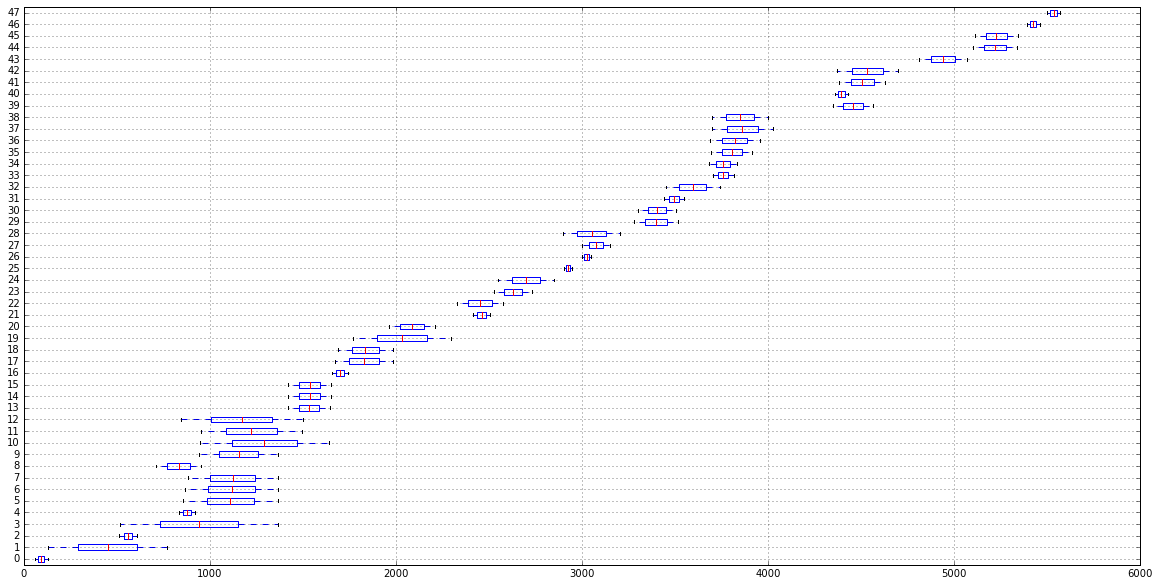

In [4]:
plt.figure(figsize=(20,10))
p = plt.boxplot(data, vert=False, positions=range(len(data)))
plt.grid()

## Sort the resources by start time 

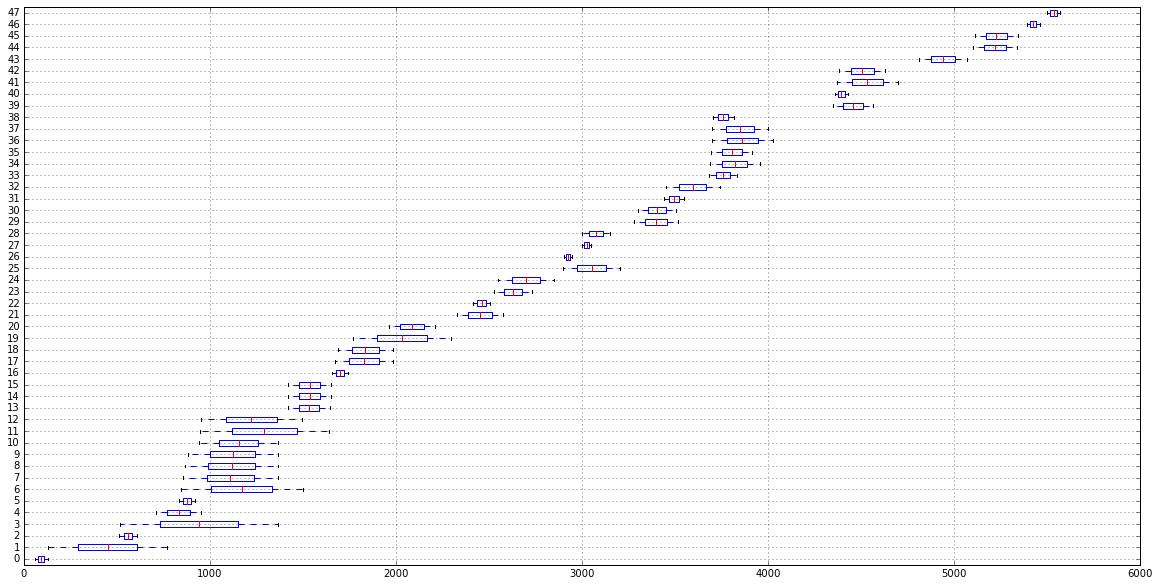

In [5]:
(d, idx) = sort_by_starttime(data)

# Plot waterfall
plt.figure(figsize=(20,10))
p = plt.boxplot(d, vert=False, positions=range(len(data)))
plt.grid()

## Remove smaller resouces that are over 90% overlaps with larger ones 

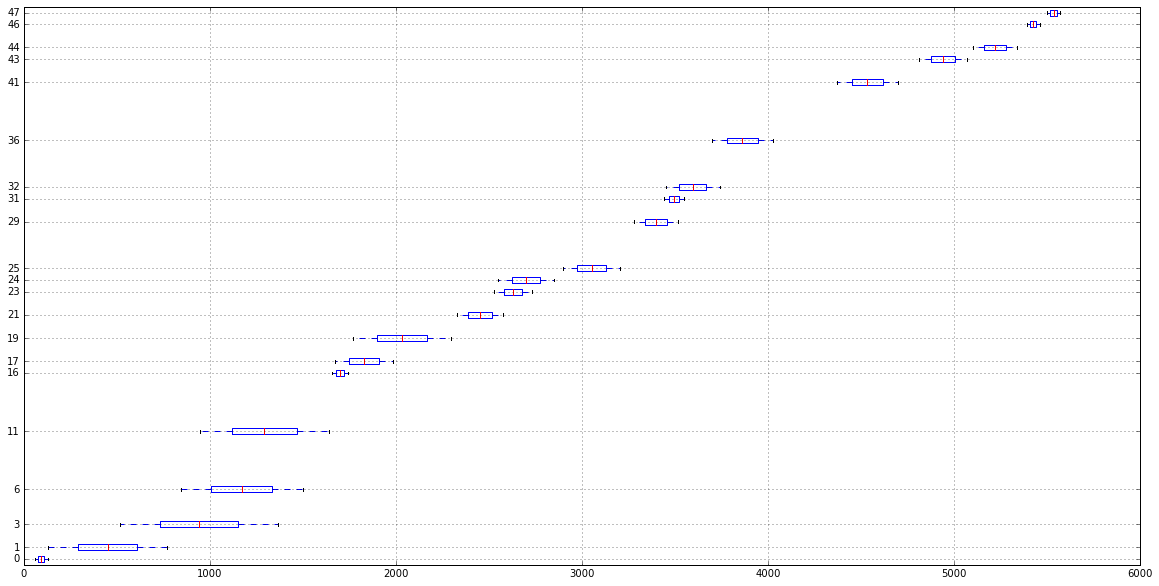

In [6]:
md, midx = merge_partial_tasks(d, min_overlap=0.9, verbose=False)
plt.figure(figsize=(20,10))
p = plt.boxplot(md, vert=False, positions=midx)
plt.grid()

## Build stages based on percentage overlap 

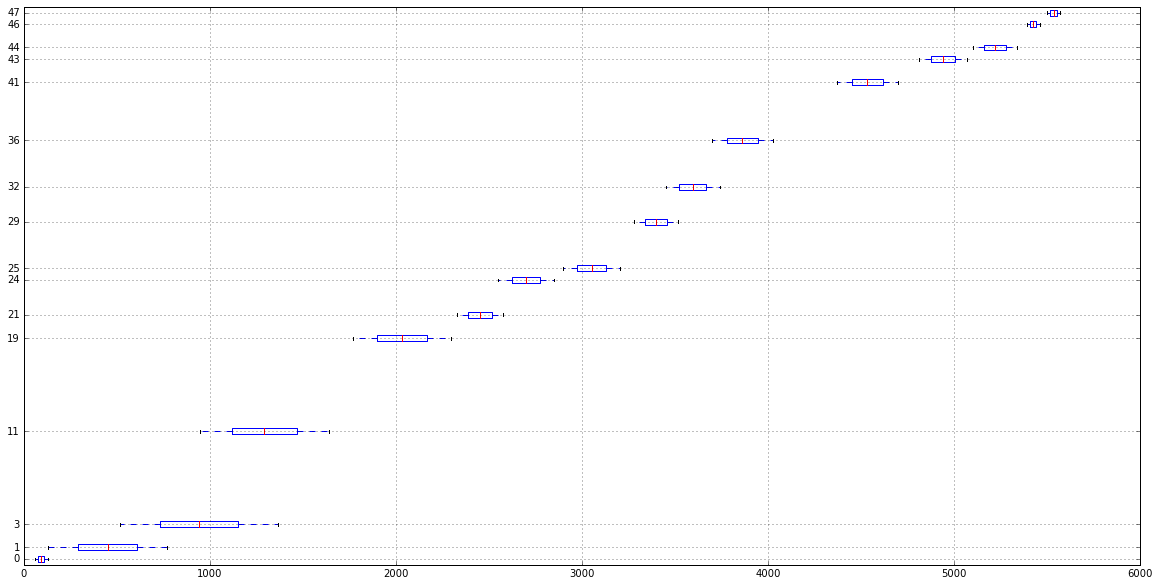

In [7]:
pd, pidx = merge_partial_tasks(md, min_overlap=0.65, verbose=False)
pidx = np.array(midx)[pidx]
plt.figure(figsize=(20,10))
p = plt.boxplot(pd, vert=False, positions=pidx)
plt.grid()

## Bottlenecks in each stage 

In [8]:
original_idx = idx[pidx]
length = np.array([j-i for (i,j) in pd])
final_sort_idx = np.argsort(-1*length)
pd_sort = [pd[i] for i in final_sort_idx]

In [9]:
print "[(index, time)]"
z = zip(original_idx[final_sort_idx], [length[i] for i in final_sort_idx])
for i in z:
    print i

[(index, time)]
(3, 845)
(10, 696)
(1, 640)
(19, 531)
(42, 332)
(37, 328)
(28, 310)
(24, 299)
(32, 289)
(43, 259)
(22, 251)
(29, 238)
(44, 234)
(0, 71)
(47, 70)
(46, 65)


## In case required analysis of how many resources left for different overlaps

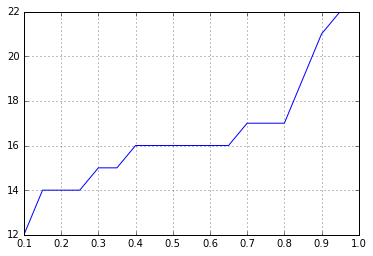

In [10]:
l = []
r = np.arange(0.1,1,0.05)
for i in r:
    md, midx = merge_partial_tasks(d, min_overlap=i, verbose=False)
    l.append(len(md))
plt.plot(r, l)
plt.grid()